<a href="https://colab.research.google.com/github/rreschke/IMT-IA/blob/master/Projeto_Pinturas_19_02009_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introdução à inteligência artificial

##Projeto final - Classificação imagens de pinturas de diversos artistas
Este arquivo deve ser entregue até dia 12/06/21. Para isso, adicione o seu RA no título do arquivo.
A finalidade deste projeto é modificar o **classificador** de uma rede neural previamente treinada, onde fica a seu critério escolher qual arquitetura do modelo VGG você irá utilizar. 
Será avaliado quais foram as camadas utilizadas, funções de ativação, métodos para evitar *overfitting*, critério de perda, otimizador e quaisquer outros métodos que alterem os hiperparâmetros da rede.

A precisão percentual será calculada pelo algoritmo no final deste arquivo.

###Configuração inicial
Para que possamos baixar o dataset do Kaggle, crie uma conta ou associe sua conta Google. Entre em "My account" clicando no canto superior direito (que seria seu usuário), dentro da sua conta vá até a sessão "API", clique no botão "Create New API Token".

Será feito o download de um arquivo chamado "kaggle.json" que permitirá acesso aos datasets no Kaggle.
Execute a célula a seguir, ela pedirá para que você insira um arquivo, portanto selecione o "kaggle.json" que será usado para fazer o download do dataset.

In [ ]:
from google.colab import files
files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d ikarus777/best-artworks-of-all-time

Saving kaggle.json to kaggle.json
100% 2.29G/2.29G [00:30<00:00, 44.4MB/s]
100% 2.29G/2.29G [00:30<00:00, 79.4MB/s]


Execute a célula a seguir para extrair os dados:

In [ ]:
!unzip /content/best-artworks-of-all-time.zip
!rm -rf /content/resized/

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: resized/resized/Henri_Rousseau_61.jpg  
  inflating: resized/resized/Henri_Rousseau_62.jpg  
  inflating: resized/resized/Henri_Rousseau_63.jpg  
  inflating: resized/resized/Henri_Rousseau_64.jpg  
  inflating: resized/resized/Henri_Rousseau_65.jpg  
  inflating: resized/resized/Henri_Rousseau_66.jpg  
  inflating: resized/resized/Henri_Rousseau_67.jpg  
  inflating: resized/resized/Henri_Rousseau_68.jpg  
  inflating: resized/resized/Henri_Rousseau_69.jpg  
  inflating: resized/resized/Henri_Rousseau_7.jpg  
  inflating: resized/resized/Henri_Rousseau_70.jpg  
  inflating: resized/resized/Henri_Rousseau_8.jpg  
  inflating: resized/resized/Henri_Rousseau_9.jpg  
  inflating: resized/resized/Henri_de_Toulouse-Lautrec_1.jpg  
  inflating: resized/resized/Henri_de_Toulouse-Lautrec_10.jpg  
  inflating: resized/resized/Henri_de_Toulouse-Lautrec_11.jpg  
  inflating: resized/resized/Henri_de_Toulouse-Lautrec_12.jpg  


In [ ]:
# Importação das bibliotecas
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset

### Definição das transformações e tamanho de lote

In [ ]:
# Classe auxiliar para aplicar transformadas em cada dataset separado
class ApplyTransform(Dataset):
    def __init__(self, dataset, transform=None, target_transform=None):
        self.dataset = dataset
        self.transform = transform
        self.target_transform = target_transform

    def __getitem__(self, idx):
        sample, target = self.dataset[idx]
        if self.transform is not None:
            sample = self.transform(sample)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return sample, target

    def __len__(self):
        return len(self.dataset)

In [ ]:
# Quantas amostras por lote 
batch_size = 4
# Porcentagem da quantidade de imagem que será definida para uso como validação e teste
test_valid_size = 0.2
# Define as transformações, fique a vontade para adicionar mais transformações!!!
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# Importação das imagens para o tipo "dataset"
data_dir = '/content/images/images'
image_dataset = datasets.ImageFolder(data_dir)

# Obter índices de treinamento que serão usados para validação
num_train = len(image_dataset)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(test_valid_size * num_train))
train_idx, valid_idx , test_idx = indices[split:], indices[:int(np.floor(split/2))], indices[int(np.floor(split/2)):split]

# Definir amostradores para obter lotes de treinamento e validação
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
test_sampler = SubsetRandomSampler(test_idx)

# Aplica as transformações para o treino e validação
train_dataset = ApplyTransform(image_dataset, transform=data_transforms['train'])
valid_dataset = ApplyTransform(image_dataset, transform=data_transforms['valid'])
test_dataset = ApplyTransform(image_dataset, transform=data_transforms['test'])

# Preparar carregadores de dados (combinar conjunto de dados e amostrador)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
    sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, 
    sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
    sampler=test_sampler)

# Especifica as classes das imagens
class_names = image_dataset.classes

data_loader = {'train':train_loader,'valid':valid_loader,'test':test_loader}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

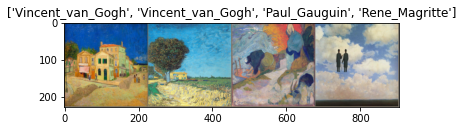

In [ ]:
# Função auxiliar
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
      plt.title(title)
    plt.pause(0.001)


# Pega um lote de treinamento
inputs, classes = next(iter(data_loader['train']))

# Faz um "grid" com as imagens
out = torchvision.utils.make_grid(inputs)

# Mostra um lote de imagens
imshow(out, title=[class_names[x] for x in classes])

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Época {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Cada época tem uma fase de treino e validação
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Modelo em treinamento
            else:
                model.eval()   # Modelo em avaliação

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in data_loader[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zera o gradiente do otimizador
                optimizer.zero_grad()

                # Analisa somente as perdas se for no treinamento
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # 'loss.backward()' + 'optimizer.step()' somente no treinamento
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Estatisticas
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / len(data_loader[phase])
            epoch_acc = running_corrects.double() / len(data_loader[phase])

            print('{} Perda: {:.4f} Precisão: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # Copia o modelo
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Treinamento completo em {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Melhor precisão: {:4f}'.format(best_acc))
    torch.save(best_model_wts,"model.pt")

    # Carrega os pesos do melhor modelo
    model.load_state_dict(best_model_wts)
    return model

### Modelo

Defina seu modelo utilizando o modelo [VGG](https://pytorch.org/docs/stable/torchvision/models.html) **pré-treinado**  e altere o classificador da rede neural.

In [ ]:
# TODO: Defina aqui qual VGG você utilizará, lembre-se que é aconselhavel usar a rede pré-treinada
model = models.vgg16(pretrained=True)

for param in model.parameters():
    param.requires_grad = False
   
# Quantidade de entradas do classificador antigo
num_ftrs = model.classifier[0].in_features

# TODO: Defina o novo classificador com entrada de num_ftrs e saída de len(class_names)
model.classifier = nn.Sequential(nn.Linear(num_ftrs, 2048),
                                 nn.Linear(2048, 256),
                                 nn.Linear(256, len(class_names)))

# Move o modelo para o dispositivo disponivel
model = model.to(device)

# TODO: Defina o critério
criterion = nn.CrossEntropyLoss()

# TODO: Defina o otimizador
optimizer = optim.Adam(model.parameters(), lr=0.001)

# TODO: Defina o "scheduler"
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.6)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


### Treinamento

In [ ]:
model = train_model(model, criterion, optimizer, exp_lr_scheduler,
                    num_epochs=10)

Época 0/9
----------
train Perda: 64.9748 Precisão: 0.9037
valid Perda: 35.0269 Precisão: 0.8091

Época 1/9
----------
train Perda: 145.9043 Precisão: 1.1618
valid Perda: 133.6309 Precisão: 1.0364

Época 2/9
----------
train Perda: 142.8614 Precisão: 1.6895
valid Perda: 221.8706 Precisão: 1.3500

Época 3/9
----------
train Perda: 155.3713 Precisão: 2.0923
valid Perda: 312.7465 Precisão: 1.5045

Época 4/9
----------
train Perda: 169.0670 Precisão: 2.4177
valid Perda: 537.1617 Precisão: 1.4136

Época 5/9
----------
train Perda: 184.8657 Precisão: 2.6923
valid Perda: 654.9546 Precisão: 1.5227

Época 6/9
----------
train Perda: 170.9902 Precisão: 2.9328
valid Perda: 753.9294 Precisão: 1.7091

Época 7/9
----------
train Perda: 65.2627 Precisão: 3.3937
valid Perda: 605.5339 Precisão: 1.7182

Época 8/9
----------
train Perda: 55.2551 Precisão: 3.4650
valid Perda: 681.0206 Precisão: 1.7864

Época 9/9
----------
train Perda: 62.9553 Precisão: 3.4256
valid Perda: 717.8793 Precisão: 1.7955

Trein

### Carregar o modelo

In [ ]:
# Carrega o modelo 
file_name = "model.pt"
model.load_state_dict(torch.load(file_name))

<All keys matched successfully>

### Avaliação do projeto

In [ ]:
# Faça o teste final para avaliação da rede
test_loss = 0.0
class_correct = list(0. for i in range(len(class_names)))
class_total = list(0. for i in range(len(class_names)))
batch_size = 4
train_on_gpu = torch.cuda.is_available()
model.eval()

for batch_idx, (data, target) in enumerate(data_loader['test']):
    # Move os tensores para a GPU se disponivel
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # Inferência 
    output = model(data)
    # Calcula a perda
    loss = criterion(output, target)
    # Atualiza a perda
    test_loss += loss.item()*data.size(0)
    # Convert as probabilidades para classe e escolhe somente a maior
    _, pred = torch.max(output, 1)    
    # Compara as predições com a classe verdadeira
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # Calcula a precisão para cada objeto
    for i in range(batch_size):
        if(correct.size==batch_size):
          label = target.data[i]
          class_correct[label] += correct[i].item()
          class_total[label] += 1

# Perda média
test_loss = test_loss/len(data_loader['test'].dataset)
print('Perda de teste: {:.6f}\n'.format(test_loss))

for i in range(len(class_names)):
    if class_total[i] > 0:
      name = class_names[i].capitalize()
      print('Precisão de teste de %5s: %2d%% (%2d/%2d)' % (
            name, 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Precisão de teste de %5s: N/A (sem dados de treinamento)' % (class_names[i]))
overall_acc = 100. * np.sum(class_correct) / np.sum(class_total)
print('\nPrecisão de teste geral: %6.2f%% (%3d/%3d)' % (
    overall_acc,
    np.sum(class_correct), np.sum(class_total)))

Perda de teste: 18.150840

Precisão de teste de Albrecht_duтха├кrer: 30% (12/39)
Precisão de teste de Albrecht_du╠иrer: 46% (15/32)
Precisão de teste de Alfred_sisley: 70% (19/27)
Precisão de teste de Amedeo_modigliani: 54% ( 6/11)
Precisão de teste de Andrei_rublev: 66% ( 4/ 6)
Precisão de teste de Andy_warhol: 57% (12/21)
Precisão de teste de Camille_pissarro:  0% ( 0/11)
Precisão de teste de Caravaggio: 14% ( 1/ 7)
Precisão de teste de Claude_monet: 50% ( 1/ 2)
Precisão de teste de Diego_rivera: 14% ( 1/ 7)
Precisão de teste de Diego_velazquez: 17% ( 4/23)
Precisão de teste de Edgar_degas: 78% (57/73)
Precisão de teste de Edouard_manet: 36% ( 4/11)
Precisão de teste de Edvard_munch: 100% ( 1/ 1)
Precisão de teste de El_greco: 75% ( 6/ 8)
Precisão de teste de Eugene_delacroix:  0% ( 0/ 3)
Precisão de teste de Francisco_goya: 12% ( 5/40)
Precisão de teste de Frida_kahlo: 70% ( 7/10)
Precisão de teste de Georges_seurat: 66% ( 2/ 3)
Precisão de teste de Giotto_di_bondone: 28% ( 2/ 7)
Pr

### Insira sua imagem (opcional)

In [ ]:
 files.upload()

In [ ]:
from PIL import Image

# Carrega imagem 
image = Image.open("download.jpeg")
# Aplica transformações
input = data_transforms['test'](image)
# Entra em modo de avaliação
model.eval()
# Muda o modelo para a CPU
model.to(torch.device("cpu"))
# Faz a inferência
logit = model(input.unsqueeze(0))
# Cria uma "camada" de softmax
softmax = nn.Softmax(dim=1)
# Aplica saida
out = softmax(logit)
# Analisa saida
value, indice = out.topk(1)
# Mostra probabilidade e classe
print("Probabilidade de {} de ser {}".format(float(value),class_names[int(indice)]))